In [156]:
import QuantLib as ql
from helper import *
import numpy as np
import matplotlib.pyplot as plt
import math

In [5]:
today = ql.Date(30, 9, 2022)
ql.Settings.instance().evaluationDate = today

In [9]:
eur3m = createYieldCurve("MarketDataBook.xlsx", "EUR3M", "DiscountFactor")

In [78]:
# Build forward curve
dates = [today + ql.Period(int(d * 360), ql.Days) for d in np.arange(0, ql.ActualActual().yearFraction(eur3m.referenceDate(), eur3m.maxDate()), 1 / 12)]
frwRates = [eur3m.forwardRate(date, date, ql.ActualActual(), ql.Simple).rate() for date in dates]
eur3mFWD = ql.YieldTermStructureHandle(ql.ForwardCurve(dates, frwRates, ql.ActualActual()))

In [69]:
# Note forward rate
T = ql.Date(25, 11, 2024)
S = ql.Date(28, 10, 2031)

golden = eur3m.forwardRate(T, S, ql.ActualActual(), ql.Simple).rate()
myFrw = (eur3m.discount(T) / eur3m.discount(S) - 1) / ql.ActualActual().yearFraction(T, S)
print("Forward rate sanity check: rel abs diff {}".format(abs(golden - myFrw) / golden))

# Instantaneous forward rate under the hood
golden = eur3m.forwardRate(S, S, ql.ActualActual(), ql.Simple).rate()
dt = 1e-4
Sminus = ql.ActualActual().yearFraction(today, S) - dt / 2
Splus = ql.ActualActual().yearFraction(today, S) + dt / 2
myFrw = (eur3m.discount(Sminus) / eur3m.discount(Splus) - 1) / dt
print("Forward rate sanity check: rel abs diff {}".format(abs(golden - myFrw) / golden))

Forward rate sanity check: rel abs diff 0.0
Forward rate sanity check: rel abs diff 0.0


## Hull White 1F

The dynamics (Ornstein-Ullenbeck SDE) of the short rate under HW1F model are 
$$dr_t = (\theta_t - a r_t) dt+ \sigma dW_t$$

where $\theta_t$ is chosen in order to fit the term structure of interest rates

In [79]:
sigma = 0.1
a = 0.1
hw_process = ql.HullWhiteProcess(eur3mFWD, a, sigma)

In [134]:
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, 30, 360, rng, False)

def hw_pathGen(num_paths, timestep):
    arr = np.zeros((num_paths, timestep + 1))
    for i in range(num_paths):
        path = seq.next().value()
        pathV = [path[j] for j in range(len(path))]
        arr[i, :] = pathV

    time = [path.time(j) for j in range(len(path))]
    return time, arr

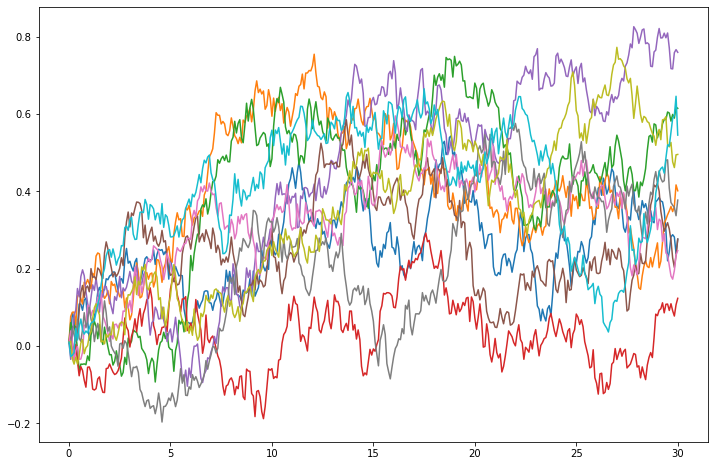

In [137]:
timestep = 360
num_paths = 10
time, arr = hw_pathGen(num_paths, timestep)
plt.figure(figsize=(12, 8))
for i in range(num_paths):
    plt.plot(time, arr[i, :])

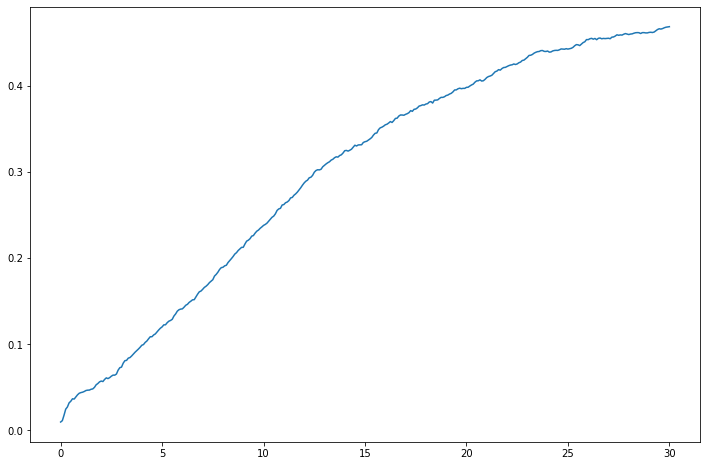

In [138]:
time, arr = hw_pathGen(1000, timestep)
hw_mean = np.mean(arr, axis=0)
plt.figure(figsize=(12, 8))
plt.plot(time, hw_mean)

## HW1F Calibration

In [148]:
# Swaption market data
data = [(1, 5, 0.1148),
        (2, 4, 0.1108),
        (3, 3, 0.1070),
        (4, 2, 0.1021),
        (5, 1, 0.1000 )]

In [158]:
def create_swaption_helpers(data, index, term_structure, engine):
    swaptions = []
    fixed_leg_tenor = ql.Period(1, ql.Years)
    fixed_leg_daycounter = ql.Actual360()
    floating_leg_daycounter = ql.Actual360()
    for d in data:
        vol_handle = ql.QuoteHandle(ql.SimpleQuote(d[2]))
        helper = ql.SwaptionHelper(ql.Period(d[0], ql.Years),
                                   ql.Period(d[1], ql.Years),
                                   vol_handle,
                                   index,
                                   fixed_leg_tenor,
                                   fixed_leg_daycounter,
                                   floating_leg_daycounter,
                                   term_structure
                                   )
        helper.setPricingEngine(engine)
        swaptions.append(helper)
    return swaptions    


def calibration_report(swaptions, data):
    columns = ["Model Price", "Market Price", "Implied Vol", "Market Vol",
               "Rel Error Price", "Rel Error Vols"]
    report_data = []
    cum_err = 0.0
    cum_err2 = 0.0
    for i, s in enumerate(swaptions):
        model_price = s.modelValue()
        market_vol = data[i][2]
        black_price = s.blackPrice(market_vol)
        rel_error = model_price/black_price - 1.0
        implied_vol = s.impliedVolatility(model_price,
                                          1e-5, 50, 0.0, 0.50)
        rel_error2 = implied_vol/market_vol-1.0
        cum_err += rel_error*rel_error
        cum_err2 += rel_error2*rel_error2
        
        report_data.append((model_price, black_price, implied_vol,
                            market_vol, rel_error, rel_error2))
    print("Cumulative Error Price: %7.5f" % math.sqrt(cum_err))
    print("Cumulative Error Vols : %7.5f" % math.sqrt(cum_err2))
    return pd.DataFrame(report_data, columns=columns,
                     index=['']*len(report_data))

In [159]:
index = ql.Euribor3M(eur3mFWD)
model = ql.HullWhite(eur3mFWD);
engine = ql.JamshidianSwaptionEngine(model)
swaptions = create_swaption_helpers(data, index, eur3mFWD, engine)

optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model.calibrate(swaptions, optimization_method, end_criteria)

a, sigma = model.params()
print("a = %6.5f, sigma = %6.5f" % (a, sigma))
calibration_report(swaptions, data)

a = 0.02997, sigma = 0.00349
Cumulative Error Price: 0.09387
Cumulative Error Vols : 0.09413


,Model Price,Market Price,Implied Vol,Market Vol,Rel Error Price,Rel Error Vols
,0.005857,0.006254,0.107516,0.1148,-0.063387,-0.063450
,0.006526,0.006677,0.108290,0.1108,-0.022613,-0.022658
,0.005911,0.005975,0.105849,0.1070,-0.010710,-0.010757
,0.004481,0.004344,0.105337,0.1021,0.031591,0.031706
,0.002467,0.002336,0.105656,0.1000,0.056306,0.056563
